# 1. Data Loading & Preprocessing

In this section, I describe how I prepared the dataset before modeling. The aim was to ensure the text data is clean, consistent, and suitable for use with various NLP models. I first filtered out incomplete records and then applied text normalisation using spaCy and NLTK. Lastly, I encoded the target variable (methodology) into a format compatible with machine learning models. These preprocessing steps are essential to ensure reliable model performance and valid evaluation.

## Import Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import re
import string
import random
import gc
import csv
import time
from datetime import datetime
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk import download
import spacy
download('stopwords')  
nlp = spacy.load("en_core_web_sm")

# Visualisation
import matplotlib.pyplot as plt

# Transformers & Torch
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification
)

# Hugging Face Datasets
from datasets import Dataset, DatasetDict, ClassLabel

# LIME for Model Explainability
!pip install -q lime
from lime.lime_text import LimeTextExplainer

# Web Tools for ArXiv Harvesting
import requests
import feedparser

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alvin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Alvin\.conda\envs\FYP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.1 Dataset Loading and Filtering

To begin, I loaded the dataset Ver5dataset_three_final.csv using Pandas. Since not all records have complete data, I filtered the DataFrame to retain only rows where the text_excerpt column is not null. This ensures that downstream tasks like tokenisation and classification are not disrupted by missing or malformed text entries. I also created a copy of the DataFrame to avoid unintended side effects during subsequent transformations.

In [2]:
df = pd.read_csv("Ver5dataset_three_final.csv")
df = df[df['text_excerpt'].notnull()].copy()

## 1.2 Text Preprocessing

Here, I implemented a preprocessing function using both spaCy and NLTK. First, I downloaded the NLTK stopword list and loaded the en_core_web_sm spaCy model. Then, I created a function that performs the following operations: lowercasing the text, removing punctuation, tokenising the input using spaCy, lemmatising each token, and optionally removing stopwords. The function helps standardise the text, reduce vocabulary noise, and focus the model on meaningful word stems. I applied this function twice to generate two different processed versions of the text: one with stopwords removed (processed_no_stopwords) and one that retains stopwords (processed_with_stopwords). This allows flexibility during model experimentation later on, as different models may perform better with or without stopwords included.

In [3]:
# Download stopwords and spaCy model
stop_words = set(stopwords.words("english"))

# Preprocessing function
def preprocess_text(text, remove_stopwords=True):
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_alpha:
            if remove_stopwords and token.text in stop_words:
                continue
            tokens.append(token.lemma_)
    return " ".join(tokens)

# Apply preprocessing 
df['processed_no_stopwords'] = df['text_excerpt'].apply(lambda x: preprocess_text(str(x), remove_stopwords=True))
df['processed_with_stopwords'] = df['text_excerpt'].apply(lambda x: preprocess_text(str(x), remove_stopwords=False))

## 1.3 Label Encoding for Methodology Classification

This block prepares the dataset for supervised classification by focusing on the methodology column, which is my target label. I removed rows with missing methodology values to ensure valid training examples, then reset the DataFrame index. I preserved the original indices using a new column called orig_idx, which helps trace predictions back to the original raw examples later (e.g., during error analysis or explainability). Finally, I used scikit-learn’s LabelEncoder to convert each unique methodology class into a numerical label. This transformation is required for the model to compute loss and evaluate predictions during training.

In [4]:
df_m = df[df['methodology'].notnull()].copy().reset_index()
df_m.rename(columns={'index': 'orig_idx'}, inplace=True)

le_m = LabelEncoder()
df_m['label'] = le_m.fit_transform(df_m['methodology'])

# 2. Token Length Distribution and Model Loading for LIME Explainability

As part of my investigation into model behavior and explainability, I conducted an analysis using the SciBERT model trained on the methodology label. The goal was to inspect token length distributions, ensure compatibility with model input requirements, and apply LIME (Local Interpretable Model-agnostic Explanations) for interpretability insights.

## 2.1 Model Loading for LIME

To apply LIME explanations, I reloaded the trained SciBERT model using PyTorch. I used the same tokeniser (allenai/scibert_scivocab_uncased) and reloaded the saved model weights (scibert_methodology_best_state.pt). I ensured the model was set to evaluation mode to prevent dropout or training-time behaviors, which could otherwise interfere with consistent prediction outputs required by LIME.

In [5]:
# Load label encoder and tokeniser 
model_name = "allenai/scibert_scivocab_uncased"
model_m = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(le_m.classes_)
)

# Load saved weights
model_m.load_state_dict(torch.load("scibert_methodology_best_state.pt"))
model_m.eval()  # model is in eval mode

C:\Users\Alvin\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## 2.2 Token Length Distribution Analysis

Before fine-tuning or interpreting model predictions, it was important to analyse the tokenized sequence lengths generated by the SciBERT tokeniser. Using the preprocessed column processed_with_stopwords (which retains full context), I calculated the distribution of token lengths across the dataset without truncation.

The histogram and statistical summary (see image) show that the majority of samples fall well below the 256-token threshold, with only 9.48% exceeding 256 tokens and 0.02% exceeding the 512-token maximum allowed by BERT-based models. Based on this, I decided that a maximum sequence length of 256 tokens would be a suitable and efficient truncation threshold for downstream model training and LIME explanations. This decision was used consistently across all extended configurations (C1–C3, etc.).

C:\Users\Alvin\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Count: 5582
count    5582.000000
mean      166.563776
std        64.506522
min        11.000000
50%       166.000000
75%       213.000000
90%       254.900000
95%       275.000000
99%       303.000000
max       596.000000
dtype: float64

% > 256 tokens: 9.48%
% > 512 tokens: 0.02%


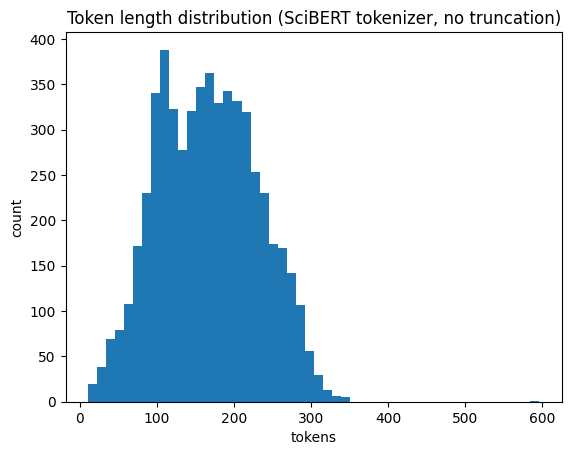

In [6]:
model_name = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

texts = df['processed_with_stopwords'].astype(str).tolist()

def lengths_in_batches(texts, batch_size=128):
    lens = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, add_special_tokens=True, truncation=False)
        # len of each input_ids sequence
        lens.extend([len(ids) for ids in enc["input_ids"]])
    return np.array(lens, dtype=np.int32)

lens = lengths_in_batches(texts, batch_size=128)

print("Count:", len(lens))
print(pd.Series(lens).describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99]))
pct_over_256 = (lens > 256).mean() * 100
pct_over_512 = (lens > 512).mean() * 100
print(f"\n% > 256 tokens: {pct_over_256:.2f}%")
print(f"% > 512 tokens: {pct_over_512:.2f}%")

# Histogram 
plt.figure()
plt.hist(lens, bins=50)
plt.title("Token length distribution (SciBERT tokenizer, no truncation)")
plt.xlabel("tokens")
plt.ylabel("count")
plt.show()

## 2.3 Tokenisation

I constructed a Hugging Face Dataset using only the samples with valid methodology labels. This dataset was then tokenised using the SciBERT tokeniser with truncation. I performed a stratified train-test split (80/20) using train_test_split to maintain class distribution, ensuring representative samples were selected for LIME interpretation.

In [6]:
dataset_m = Dataset.from_pandas(df_m[['processed_with_stopwords', 'label', 'orig_idx']])
dataset_m = dataset_m.cast_column("label", ClassLabel(num_classes=len(le_m.classes_), names=list(le_m.classes_)))

Casting the dataset: 100%|██████████████████████████████████████████████| 5582/5582 [00:00<00:00, 107282.11 examples/s]


In [8]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

def tokenize_function(example):
    return tokenizer(example["processed_with_stopwords"], padding="max_length", truncation=True)

tokenized_m = dataset_m.map(tokenize_function, batched=True)

split_m = tokenized_m.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_m = split_m["train"]
test_m = split_m["test"] 

C:\Users\Alvin\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map:   0%|                                                                             | 0/5582 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|████████████████████████████████████████████████████████████████| 5582/5582 [00:00<00:00, 7718.60 examples/s]


## 2.4 Applying LIME for Interpretability

I employed LIME Text Explainer, which treats the model as a black box and perturbs the input text to learn the most influential tokens for prediction. I randomly selected three samples from the test set for analysis. For each sample, I:

- Retrieved the original text and true label.
- Ran LIME to identify the top 10 features (words) influencing the model's prediction.
- Printed the predicted and actual labels for comparison.
- Saved the HTML visualisation from LIME, which shows highlighted words and their contribution toward the predicted class.

This helped me understand what textual patterns the model relies on, especially within each of the four methodology classes. This interpretability check was critical in validating the model's decision logic and guided further steps like rule-based classification using LIME-derived keywords.

In [ ]:
# Class names for LIME
class_names = le_m.classes_.tolist()

# Prediction wrapper
def predict_proba(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
    inputs = {k: v.to(model_m.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model_m(**inputs).logits
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

# LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

# Pick random test samples
sample_indices = random.sample(range(len(test_m)), 3)

for idx in sample_indices:
    # Get original index from test set
    orig_idx = test_m[idx]['orig_idx']
    sample_text = df_m.loc[orig_idx]['text_excerpt']
    true_label = df_m.loc[orig_idx]['methodology']

    # Run LIME
    exp = explainer.explain_instance(sample_text, predict_proba, num_features=10, top_labels=1, num_samples=1000)
    pred_label_idx = exp.top_labels[0]
    pred_label = class_names[pred_label_idx]

    # Display
    print(f"\n=== Sample {idx} ===")
    print(f"True Label     : {true_label}")
    print(f"Predicted Label: {pred_label}")
    exp.save_to_file(f"lime_methodology_sample_{idx}.html")
    print(f"[Saved] lime_methodology_sample_{idx}.html")


=== Sample 302 ===
True Label     : Theoretical / Conceptual
Predicted Label: Theoretical / Conceptual
[Saved] lime_methodology_sample_302.html


# 3. LIME Keyword Discovery, Paper Harvesting, and Rule-Based Classification

At this stage of the project, I extended my analysis beyond model evaluation by building interpretable explanations, collecting real-world data, and applying a rule-based classification system. These were implemented in three parts: analyzing feature importance using LIME, harvesting academic papers from arXiv, and building a simple rule-based classifier using methodology-specific keywords.

## 3.1 Extracting Important Keywords Using LIME

I performed a local interpretability analysis of my fine-tuned methodology classification model using the LIME (Local Interpretable Model-Agnostic Explanations) framework. This allowed me to uncover which keywords my model was relying on for its predictions.

First, I defined a fixed number of correctly predicted test samples (N=50) from the validation set. These samples were selected by passing individual inputs through the fine-tuned SciBERT model (model_m) and matching the predicted label with the true label.

Then, I applied LIME to each of these samples using the predict_proba function that wraps the model. LIME perturbs each input and fits a simple surrogate model locally to highlight important features (in this case, words) that influenced the model's decision. I extracted the top 10 most important keywords (NUM_FEATURES) from each sample and tracked both:
- How often each keyword appeared across samples per methodology label.
- The cumulative importance weight (magnitude of influence) for each keyword.

The output summarises the top influential keywords for each methodology class. This process provided an interpretable layer on top of my model, helping me identify model-reliant linguistic features like "prototype", "interview", or "conceptual" that align with each research methodology.

In [10]:
# CONFIGURATION 
N = 200  # Number of correctly predicted samples to analyze
NUM_FEATURES = 10
NUM_PERTURBATIONS = 300

stop_words = set(stopwords.words("english"))
punct_table = str.maketrans('', '', string.punctuation)

# Data Structures 
keyword_weight_counter = defaultdict(Counter)  # total importance weight
keyword_sample_counter = defaultdict(Counter)  # count of how many samples keyword appeared in
correct_samples = []

# Identify Correct Predictions
for i in range(len(test_m)):
    orig_idx = test_m[i]['orig_idx']
    sample_text = df_m.loc[orig_idx]['text_excerpt']
    true_label = df_m.loc[orig_idx]['methodology']
    
    # Predict label
    inputs = tokenizer(sample_text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(model_m.device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model_m(**inputs).logits
        pred_label_idx = torch.argmax(logits, dim=1).item()
    pred_label = class_names[pred_label_idx]

    if pred_label == true_label:
        correct_samples.append((sample_text, true_label))
    if len(correct_samples) >= N:
        break

print(f"Running LIME on {len(correct_samples)} correctly predicted samples...")

# Run LIME and extract keywords
for idx, (sample_text, label) in enumerate(correct_samples):
    try:
        exp = explainer.explain_instance(
            sample_text,
            predict_proba,
            num_features=NUM_FEATURES,
            top_labels=1,
            num_samples=NUM_PERTURBATIONS
        )
        label_idx = class_names.index(label)
        keywords = exp.as_list(label=label_idx)

        seen_words = set()
        for word, weight in keywords:
            # Pre-clean word
            clean_word = word.lower().translate(punct_table).strip()
            if not clean_word or clean_word in stop_words or not clean_word.isalpha():
                continue
            keyword_weight_counter[label][clean_word] += abs(weight)
            if clean_word not in seen_words:
                keyword_sample_counter[label][clean_word] += 1
                seen_words.add(clean_word)

        print(f"[{idx+1}/{N}] Processed sample for '{label}'")

    except Exception as e:
        print(f"Error processing sample {idx}: {e}")

    # Free memory
    torch.cuda.empty_cache()
    gc.collect()

# Display Top Keywords
print("\n=== Top Keywords Per Methodology ===")
for label in class_names:
    print(f"\n{label}:")
    words = keyword_sample_counter[label].most_common()
    for word, sample_count in words[:10]:
        total_weight = keyword_weight_counter[label][word]
        print(f"  {word:20s} (samples: {sample_count:2d}, weight: {total_weight:.4f})")

Running LIME on 200 correctly predicted samples...
[1/200] Processed sample for 'Theoretical / Conceptual'
[2/200] Processed sample for 'Design Science / System Design'
[3/200] Processed sample for 'Theoretical / Conceptual'
[4/200] Processed sample for 'Design Science / System Design'
[5/200] Processed sample for 'Design Science / System Design'
[6/200] Processed sample for 'Design Science / System Design'
[7/200] Processed sample for 'Design Science / System Design'
[8/200] Processed sample for 'Design Science / System Design'
[9/200] Processed sample for 'Design Science / System Design'
[10/200] Processed sample for 'Design Science / System Design'
[11/200] Processed sample for 'Design Science / System Design'
[12/200] Processed sample for 'Design Science / System Design'
[13/200] Processed sample for 'Design Science / System Design'
[14/200] Processed sample for 'Design Science / System Design'
[15/200] Processed sample for 'Design Science / System Design'
[16/200] Processed sample

## 3.2 Collection of papers (ARXIV)

This is a custom-built paper collection tool that harvested a large number of research papers from the arXiv
 API, with a focus on relevant categories (e.g., cs, stat, math, econ, etc.).

I used the official arXiv API to query papers in batches (BATCH_SIZE = 100), across eight disciplines, with up to 5,000 results per category.

This script resulted in a dataset of academic abstracts that were categorised by field and subfield. The final dataset was saved as arxiv_bulk_download.csv. This dataset serves as an unlabeled input for further experimentation and testing of external generalisability of the classifiers I trained on manually labeled data.

In [11]:
# CONFIG
OUTPUT_FILE = "arxiv_bulk_download.csv"
CATEGORY_PREFIXES = [
    "cs", "math", "stat", "econ", "q-bio", "physics", "eess", "astro-ph"
]
BATCH_SIZE = 100
MAX_RESULTS_PER_CATEGORY = 5000
SLEEP_TIME = 3  # seconds between API calls

# Label Maps
priority_subfield_map = {
    "cs.CL": "Natural Language Processing",
    "cs.LG": "Machine Learning",
    "cs.HC": "Human Computer Interaction",
    "cs.SE": "Software Engineering",
    "cs.CY": "Information Systems",
    "cs.DL": "Computing Education",
    "cs.ET": "Education Systems",
    "math.ST": "Statistics",
    "econ.EM": "Econometrics",
    "stat.ML": "Statistical Machine Learning",
    "q-bio.NC": "Neural and Cognitive Modeling",
}

discipline_map = {
    "cs": "Computer Science",
    "math": "Mathematics",
    "stat": "Statistics",
    "q-bio": "Quantitative Biology",
    "econ": "Economics",
    "eess": "Electrical Engineering and Systems Science",
    "physics": "Physics",
    "astro-ph": "Astrophysics",
}

def get_discipline(cat):
    return discipline_map.get(cat.split(".")[0], "Other")

def get_subfield(categories):
    for code in priority_subfield_map:
        if code in categories:
            return priority_subfield_map[code]
    return "Other"

#  HARVEST 
all_ids = set()
total_saved = 0
all_rows = []

for prefix in CATEGORY_PREFIXES:
    print(f"\nStarting category: {prefix}")
    for start in range(0, MAX_RESULTS_PER_CATEGORY, BATCH_SIZE):
        print(f"  Fetching {prefix} results {start} to {start + BATCH_SIZE}...")

        url = (
            f"https://export.arxiv.org/api/query?"
            f"search_query=cat:{prefix}*&"
            f"start={start}&max_results={BATCH_SIZE}&"
            f"sortBy=submittedDate&sortOrder=descending"
        )

        try:
            response = requests.get(url)
            feed = feedparser.parse(response.content)
        except Exception as e:
            print(f"  Request failed: {e}")
            break

        if not feed.entries:
            print(f"  No results returned.")
            break

        new_entries = 0
        for entry in feed.entries:
            paper_id = entry.id
            if paper_id in all_ids:
                continue

            all_ids.add(paper_id)
            title = entry.title.strip().replace("\n", " ")
            abstract = entry.summary.strip().replace("\n", " ")
            pdf_url = next((l.href for l in entry.links if l.type == "application/pdf"), "")
            primary_cat = entry.arxiv_primary_category['term']
            all_cats = [t['term'] for t in entry.tags]
            subfield = get_subfield(all_cats)
            discipline = get_discipline(primary_cat)

            all_rows.append([
                title, abstract, ",".join(all_cats), primary_cat, pdf_url, subfield, discipline
            ])
            new_entries += 1

        total_saved += new_entries
        print(f"  Batch done. New entries: {new_entries}, Total: {total_saved}")
        time.sleep(SLEEP_TIME)

# Save to CSV
columns = ["title", "abstract", "categories", "primary_category", "pdf_url", "subfield", "discipline"]
df = pd.DataFrame(all_rows, columns=columns)
df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8')

print(f"\nDone. {total_saved} unique papers saved to: {OUTPUT_FILE}")


Starting category: cs
  Fetching cs results 0 to 100...
  Batch done. New entries: 100, Total: 100
  Fetching cs results 100 to 200...
  No results returned.

Starting category: math
  Fetching math results 0 to 100...
  Batch done. New entries: 94, Total: 194
  Fetching math results 100 to 200...
  No results returned.

Starting category: stat
  Fetching stat results 0 to 100...
  Batch done. New entries: 89, Total: 283
  Fetching stat results 100 to 200...
  Batch done. New entries: 100, Total: 383
  Fetching stat results 200 to 300...
  Batch done. New entries: 100, Total: 483
  Fetching stat results 300 to 400...
  Batch done. New entries: 100, Total: 583
  Fetching stat results 400 to 500...
  Batch done. New entries: 100, Total: 683
  Fetching stat results 500 to 600...
  Batch done. New entries: 100, Total: 783
  Fetching stat results 600 to 700...
  Batch done. New entries: 100, Total: 883
  Fetching stat results 700 to 800...
  Batch done. New entries: 100, Total: 983
  Fetch

## 3.3 Rule-Based Classifier on Raw Data without Methodology

Using the data harvested from arXiv, I built a lightweight rule-based classifier to predict the methodology of papers based solely on keyword presence in the abstract text. This part of the pipeline is completely independent of the neural network models.

I manually curated four lists of methodology-specific keywords for:
- Design Science / System Design
- Mixed Methods
- Qualitative
- Theoretical / Conceptual

Each paper's abstract was lowercased and searched for the presence of these keywords using regular expressions. A score was computed for each methodology by counting keyword matches. The methodology with the highest score was assigned as the prediction, unless all scores were zero, in which case the label was "Uncertain".

This rule-based method served two purposes:
- Interpretability : I could clearly inspect which keywords triggered certain classifications.
- Bootstrapping :  It offered a way to automatically label large unlabeled corpora (like arXiv papers) for future experiments.
- The final results were saved to a new CSV (arxiv_bulk_download_wMethodology.csv) with a predicted methodology column added.

In [12]:
# Load CSV 
df = pd.read_csv("arxiv_bulk_download.csv") 

# Keyword rules per methodology 
rules = {
    "Design Science / System Design": [
        "dataset", "evaluate", "propose", "training", "benchmark", "proposed",
        "outperforms", "implementation", "system", "architecture", 
        "prototype", "algorithm", "model", "design", "development", 
        "testing", "validation", "performance", "experiment", "optimization"
    ],
    "Mixed Methods": [
        "survey", "interview", "quantitative", "mixed methods",
        "participants", "framework", "empirical", "multi-method", "case study",
        "triangulation", "data integration", "sequential", "concurrent", 
        "questionnaire", "statistical", "thematic analysis", "mixed-method"
    ],
    "Qualitative": [
        "interviews", "semi-structured", "qualitative", "grounded theory", 
        "thematic", "open-ended", "narrative", "focus group", "field notes", 
        "transcripts", "ethnography", "phenomenology", "observation", 
        "coding", "discourse", "interpretive", "participant observation"
    ],
    "Theoretical / Conceptual": [
        "theoretical", "framework", "conceptual", "model", "hypothesis",
        "proposition", "derive", "formalize", "assumption", "philosophical",
        "literature review", "synthesis", "theory", "concept", "paradigm", 
        "ontology", "epistemology", "abstraction"
    ]
}

# Scoring function
def classify_methodology(text):
    text = str(text).lower()
    scores = {}

    for label, keywords in rules.items():
        count = sum(bool(re.search(r'\b' + re.escape(word) + r'\b', text)) for word in keywords)
        scores[label] = count

    best_label = max(scores, key=scores.get)
    return best_label if scores[best_label] > 0 else "Uncertain"

# Apply classifier
df['predicted_methodology'] = df['abstract'].apply(classify_methodology)

# Save/preview
print(df[['abstract', 'predicted_methodology']].head())
df.to_csv("arxiv_bulk_download_wMethodology.csv", index=False)


                                            abstract  \
0  Generative models typically sample outputs ind...   
1  Visual diffusion models achieve remarkable pro...   
2  Recent advances in diffusion models have broug...   
3  3D content generation has recently attracted s...   
4  Parametric body models offer expressive 3D rep...   

            predicted_methodology  
0                   Mixed Methods  
1  Design Science / System Design  
2        Theoretical / Conceptual  
3  Design Science / System Design  
4  Design Science / System Design  
